In [1]:
import os
import torch

import scanpy as sc
import numpy as np
import pandas as pd
import gseapy as gp

from tqdm import tqdm
from sklearn.cluster import KMeans
from contrastive_vi.model.contrastive_vi import ContrastiveVIModel
from scripts import constants
from scvi._settings import settings
import logging

Global seed set to 0


In [2]:
settings.seed = 0
settings.verbosity = logging.CRITICAL
device = "cuda:1"
dataset = "mcfarland_2020"

Global seed set to 0


In [3]:
seeds = constants.DEFAULT_SEEDS
latent_size = 10

In [4]:
from collections import defaultdict

split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
label_key = constants.DATASET_SPLIT_LOOKUP[dataset]["label_key"]

adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
    )
)
ContrastiveVIModel.setup_anndata(adata, layer="count")

target_indices = np.where(adata.obs[split_key] != background_value)[0]
target_adata = adata[target_indices]
background_indices = np.where(adata.obs[split_key] == background_value)[0]
background_adata = adata[background_indices]


contrastiveVI_model_list = []
scVI_model_list = []
for seed in tqdm(seeds[:2]):
    result_dir = os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/contrastiveVI/latent_{latent_size}",
        f"{seed}",
    )
    contrastiveVI_model_list.append(
        torch.load(
            os.path.join(result_dir, "model.ckpt"),
            map_location=device,
        ),
    )

    scvi_result_dir = os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/scVI_with_background/latent_{latent_size}",
        f"{seed}",
    )

    scVI_model_list.append(
        torch.load(
            os.path.join(scvi_result_dir, "model.ckpt"),
            map_location=device,
        ),
    )

contrastiveVI_background_imputed_total= [
    model.get_normalized_expression(background_adata, n_samples=100)["background"].values for model in tqdm(contrastiveVI_model_list)]
contrastiveVI_target_imputed_total = [
    model.get_normalized_expression(target_adata, n_samples=100)["salient"].values for model in tqdm(contrastiveVI_model_list)]

scVI_background_imputed_total = [
    model.get_normalized_expression(background_adata, n_samples=100).values for model in tqdm(scVI_model_list)]
scVI_target_imputed_total = [
    model.get_normalized_expression(target_adata, n_samples=100).values for model in tqdm(scVI_model_list)]

/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.82s/it]


In [5]:
from sklearn.metrics import mean_absolute_error

metric = mean_absolute_error

scVI_vs_scVI_background = []
contrastiveVI_vs_scVI_background = []
scVI_vs_scVI_target = []
contrastiveVI_vs_scVI_target = []

scVI_background_adata_reference = scVI_background_imputed_total[0]
scVI_background_adata_imputed = scVI_background_imputed_total[1]
contrastiveVI_background_adata_imputed = contrastiveVI_background_imputed_total[1]

scVI_target_adata_reference = scVI_target_imputed_total[0]
scVI_target_adata_imputed = scVI_target_imputed_total[1]
contrastiveVI_target_adata_imputed = contrastiveVI_target_imputed_total[1]

for idx in tqdm(range(adata.shape[1])):
    scVI_vs_scVI_background.append(metric(
        scVI_background_adata_reference[:, idx], scVI_background_adata_imputed[:, idx]
    ))

    contrastiveVI_vs_scVI_background.append(metric(
        scVI_background_adata_reference[:, idx], contrastiveVI_background_adata_imputed[:, idx]
    ))

    scVI_vs_scVI_target.append(metric(
        scVI_target_adata_reference[:, idx], scVI_target_adata_imputed[:, idx]
    ))

    contrastiveVI_vs_scVI_target.append(metric(
        scVI_target_adata_reference[:, idx], contrastiveVI_target_adata_imputed[:, idx]
    ))

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1447.35it/s]


The formula for $R^2$ is

$$ R^2 = 1 - \frac{\sum_{i}(y_i - \hat{y_i})^2}{\sum_{i}(y_i - \bar{y}_i)^2}$$

In our case, since we want to compute $R^2$ with respect to the line $y = x$, $\hat{y}_i$ can be replaced with $x_i$. 

In [6]:
def calc_r_squared(x, y):
    residuals = np.array(y) - np.array(x)
    abs_residuals = np.abs(residuals)

    diff_from_mean = np.array(y) - np.mean(y)
    abs_diff_from_mean = np.abs(diff_from_mean)

    r_squared = 1 - np.sum(abs_residuals**2) / np.sum(abs_diff_from_mean**2)
    return r_squared

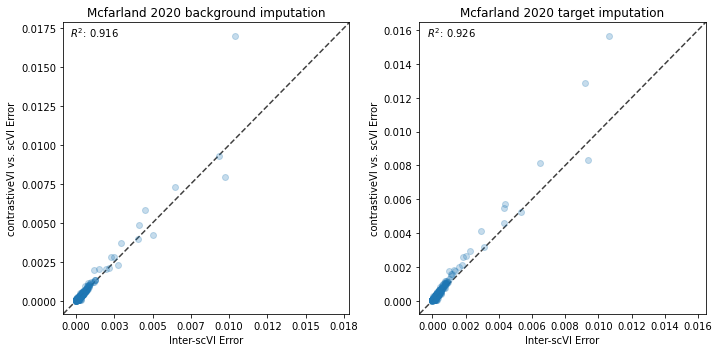

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.ticker import FormatStrFormatter


fig, full_axes = plt.subplots(1, 2, figsize=(10, 5))

ax = full_axes[0]

ax.scatter(
    scVI_vs_scVI_background,
    contrastiveVI_vs_scVI_background,
    alpha=0.25
)

dataset_name_formatted = dataset.replace('_', ' ').capitalize()

ax.set_ylabel("contrastiveVI vs. scVI Error")
ax.set_xlabel("Inter-scVI Error")

ax.set_title(f"{dataset_name_formatted} background imputation")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_xlim(lims)
ax.set_ylim(lims)

r_squared = calc_r_squared(scVI_vs_scVI_background, contrastiveVI_vs_scVI_background)

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.annotate("$R^2$: {:.3f}".format(r_squared), xy=(0.025, 0.95), xycoords='axes fraction')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax = full_axes[1]

ax.scatter(
    scVI_vs_scVI_target,
    contrastiveVI_vs_scVI_target,
    alpha=0.25
)
dataset_name_formatted = dataset.replace('_', ' ').capitalize()

ax.set_ylabel("contrastiveVI vs. scVI Error")
ax.set_xlabel("Inter-scVI Error")

ax.set_title(f"{dataset_name_formatted} target imputation")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_xlim(lims)
ax.set_ylim(lims)

r_squared = calc_r_squared(scVI_vs_scVI_target, contrastiveVI_vs_scVI_target)


ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.annotate("$R^2$: {:.3f}".format(r_squared), xy=(0.025, 0.95), xycoords='axes fraction')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.tight_layout()